# Modelización Responsable

En este notebook enseñamos los resultados de los cuatro pilares que explicaran el 30% de la puntuación:

- Explicabilidad 
- Transparencia
- Justicia
- Sostenibilidad ambiental

Importamos librerias

In [57]:
#!pip install aif360

import aif360
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from malbecs.modeling import train as tr
from malbecs.modeling import models as mm

seed = 99

Generamos datasets

In [33]:
#Lectura y preparación de datos

wine_data = pd.read_csv('../data/final/wine_final.csv')
eto_data = pd.read_csv('../data/final/eto_final.csv')
meteo_data = pd.read_csv('../data/final/meteo_final.csv')

data = tr.merge_data(
    wine_data,
    eto_data,
    meteo_data
)

data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)
data_final = tr.filter_camp(data, min_camp=22, max_camp=22)
train, test = tr.train_test_split(data_train, test_camp=21)
X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca', 
    'id_zona',
    'id_estacion', 
    'variedad',
    "modo", 
    "tipo",
    "color", 
    "prod_shift1_gt_shift2"
]
num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)

## Explicabilidad

Para  una  mejor  adopción  de  la  IA  los  modelos  deber  ser  explicables,  debemos 
evitar hablar de modelos de  caja blanca / negra. 

En el desarrollo de  todo modelo 
debe tenerse en cuenta la explicabilidad desde el diseño, un modelo explicable se 
integra en la gestión de  forma más rápida que  uno que  no lo es, incluso modelos 
no  explicables  pueden  llegar  a  no  utilizarse  nunca  aun  teniendo  una  muy  buena 
precisión.

Nuestro mejor modelo fue creado utilizando el algoritmo **Random Forest**. Creemos que este algoritmo tiene una alta capacidad de predicción como tambien de explicabilidad. Nos pareció un buen punto medio entre modelos simples como regresiones lineales y redes neuronales, donde la explicabilidad es menor.

A partir de librerias como **Shap**, podemos visualizar la explicabilidad a partir de gráficos interesantes.

### Importancia de variables

En términos generales, la importancia de una característica indica cuánto contribuye esa característica a la predicción realizada por el modelo. Una característica con una importancia alta significa que tiene un mayor efecto en la predicción, mientras que una característica con una importancia baja significa que tiene un efecto menor.

La importancia de las características se calcula como la disminución de la impureza del nodo, ponderada por la probabilidad de llegar a ese nodo. La probabilidad del nodo se puede calcular dividiendo el número de muestras que llegan al nodo por el número total de muestras. Cuanto mayor sea el valor, más importante será la característica.

In [39]:
#Creamos función para visualizar importancia de variables

def show_feat_imps(feat_imp, feat_names):
    pd.DataFrame(
        feat_imp,
        index=feat_names,
        columns=["feat_imp"]
    ).sort_values("feat_imp")[-10:].plot(kind='barh', figsize=(6, 15))

Como puede verse debajo, las variables que mas peso tienen en las predicciones del modelo son las que muestran agregaciones de producciones pasadas.

Tambien se destaca la superficie, la relación zona-producción y el modo.

In [ ]:
%%time 
models = []
for i in range(10):
    m = mm.get_final_model()
    m.set_params(randomforestregressor__random_state=mm.seed*(1+i))
    m.fit(X, y)
    models.append(m)

preds_final = []
for model in models:
    preds_final.append(model.predict(X_final))
y_pred_final = np.mean(preds_final,0)

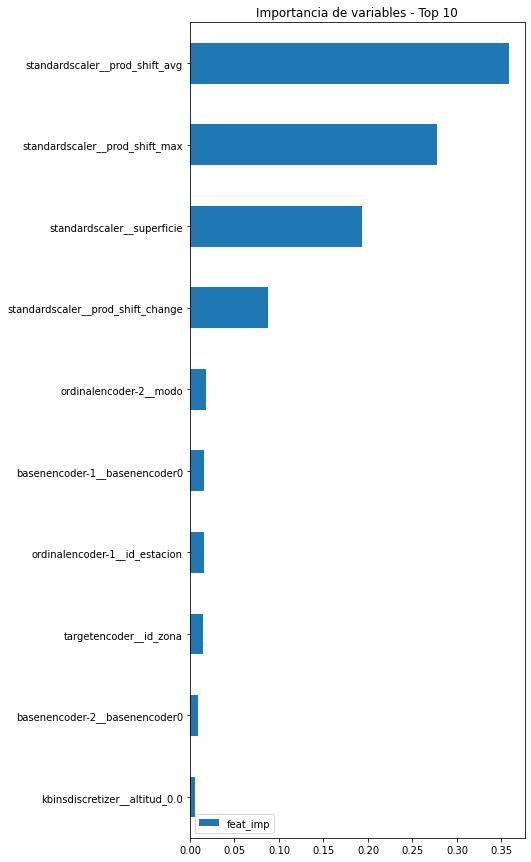

In [58]:
#Fiteamos modelo y evaluamos importancia
m = mm.get_final_model()
m.fit(X_train,y_train)

show_feat_imps(
    m[-1].feature_importances_,
    m[:-1].get_feature_names_out(),
)

plt.title('Importancia de variables - Top 10')
plt.show()

La libreria **shap** otorga una visualización más llamativa de las importancias de variables:

In [47]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(m[-1])

Obtenemos una muestra para que no tarde tanto tiempo el shap_value

In [48]:
x_sample = X.sample(int(0.7*X.shape[0]))
x_sample_trans = pd.DataFrame(
    m[:-1].transform(x_sample),
    columns=m[:-1].get_feature_names_out(),
)

In [49]:
shap_values = explainer.shap_values(x_sample_trans)

Valores altos (rojos) de las variables de producciones pasadas y superficies, por ejemplo, otorgan una prediccion (shap value) alta de la producción.

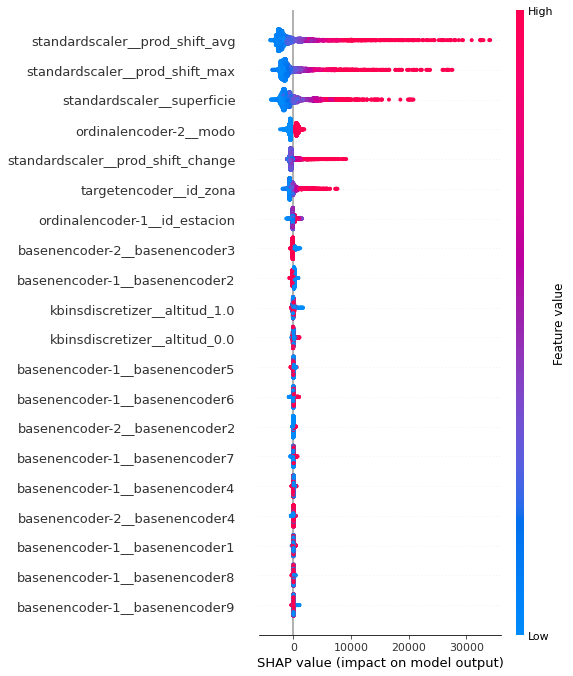

In [53]:
shap.summary_plot(shap_values, x_sample_trans)

Por ejemplo:

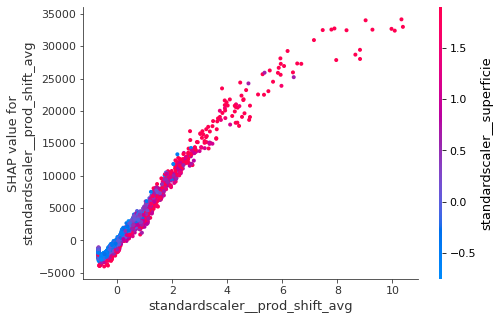

In [54]:
shap.dependence_plot('standardscaler__prod_shift_avg', shap_values, x_sample_trans)

### Asi mismo, realizamos un análisis de errores para mejorar la comprensión del modelo predictivo

Creamos una variable que muestre el error de las predicciones

In [59]:
preds = m.predict(X_test)

In [62]:
from sklearn.metrics import mean_squared_error
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print(f'RMSE test: {rmse_score(y_test,preds)}')

RMSE test: 5449.569967959719


Visualizamos diferencias

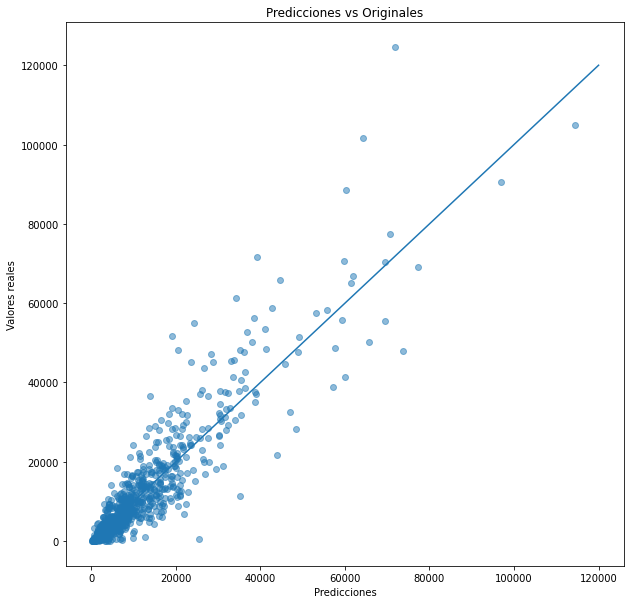

In [121]:
plt.figure(figsize=(10,10))
plt.scatter(x=preds, y=y_test , alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Predicciones vs Originales')
plt.show()

Generamos df donde evaluaremos el error, agregando una columna que calcule la diferencia entre el valor real de la producción y la prediccion

In [89]:
df_errores = X_test.copy()
df_errores['prediccion'] = preds
df_errores['produccion'] = y_test
df_errores['error'] = abs(df_errores.prediccion - df_errores.produccion)


Visualizamos distribucion del error

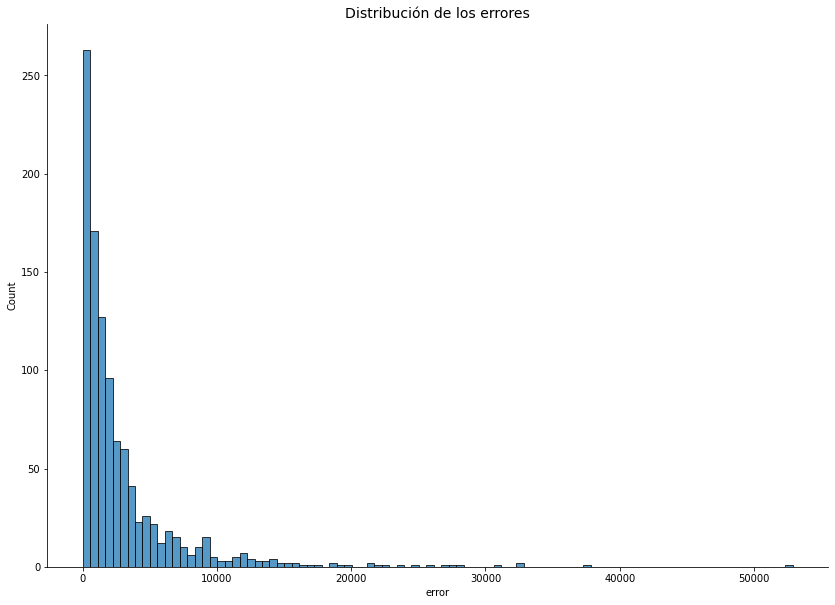

In [101]:
sns.displot(df_errores.error, height=8.27, aspect=11.7/8.27)
plt.title('Distribución de los errores', fontsize=14)
plt.show()

Podemos ver que los errores grandes (tomamos los mayores a 20.000kg) son causados por cambios drásticos entre la produccion original y sus valores pasados.

Por ejemplo, hay fincas con valores pasados de produccion de ~30.000kg, que en 2021 pasaron a producir unicamente 500kg.

In [116]:
df_errores[df_errores.error > 20000][['prod_shift1','prod_shift2','prod_shift_avg','produccion','prediccion','error',]]

,prod_shift1,prod_shift2,prod_shift_avg,produccion,prediccion,error
7484,6660.00,63170.00,34915.00,28370.00,48402.70,20032.70
7491,27380.46,50781.03,39080.74,21709.86,43816.97,22107.11
7509,54260.00,82800.00,68530.00,101750.00,64196.13,37553.87
7528,52589.89,42674.85,47632.37,65959.74,44613.57,21346.17
7530,99360.10,62695.15,81027.63,124620.26,71755.58,52864.68
7533,71218.52,55296.50,63257.51,88416.12,60247.71,28168.42
7580,34175.40,25607.40,29891.40,511.50,25424.41,24912.91
7601,20508.00,26232.00,23370.00,48168.00,20580.27,27587.73
7732,75660.00,78920.00,77290.00,48060.00,73693.53,25633.53
7748,31394.00,19156.50,25275.25,55077.00,24327.49,30749.51


Los errores estan altamente correlacionados con la produccion actual y pasada, como tambien con la superficie, como era de esperarse.

In [88]:
df_errores.corr()['error'].sort_values(ascending=False).head(20)


error                             1.00
produccion                        0.67
prediccion                        0.59
prod_shift_max                    0.57
superficie                        0.57
prod_shift_avg                    0.56
prod_shift2                       0.54
sup_shift1                        0.54
prod_shift1                       0.53
prod_var_shift_2                  0.53
prod_var_shift_1                  0.52
sup_shift2                        0.51
prod_finca_shift_1                0.42
prod_finca_shift_1.1              0.42
sup_tot_camp_finca                0.40
superficie_total                  0.38
n_var_camp_finca                  0.24
modo                              0.19
MeanSnowAmountLocalDayMaxMonth1   0.19
MeanVisibilityLocalDayMaxMonth4   0.18
Name: error, dtype: float64

No hay una clara relacion entre errores y superficies, pero si la hay con las producciones más altas. Como se enseño previamente, el modelo encuentra mayor dificultad en predecir estas ultimas.

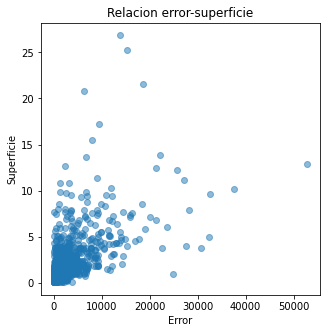

In [120]:
plt.figure(figsize=(5,5))
plt.scatter(x=df_errores.error, y=df_errores.superficie , alpha=0.5)
plt.xlabel('Error')
plt.ylabel('Superficie')
plt.title('Relacion error-superficie')
plt.show()

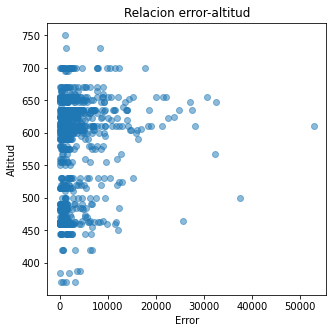

In [122]:
plt.figure(figsize=(5,5))
plt.scatter(x=df_errores.error, y=df_errores.altitud , alpha=0.5)
plt.xlabel('Error')
plt.ylabel('Altitud')
plt.title('Relacion error-altitud')
plt.show()

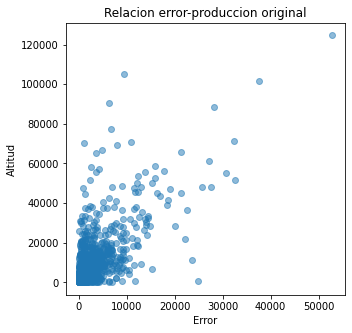

In [124]:
plt.figure(figsize=(5,5))
plt.scatter(x=df_errores.error, y=df_errores.produccion , alpha=0.5)
plt.xlabel('Error')
plt.ylabel('Altitud')
plt.title('Relacion error-produccion original')
plt.show()

Así mismo, las variedades con mayor produccion tienen un mayor error de produccion. Algunas que se destacan son, por ejemplo, la variedad 32 o 17.

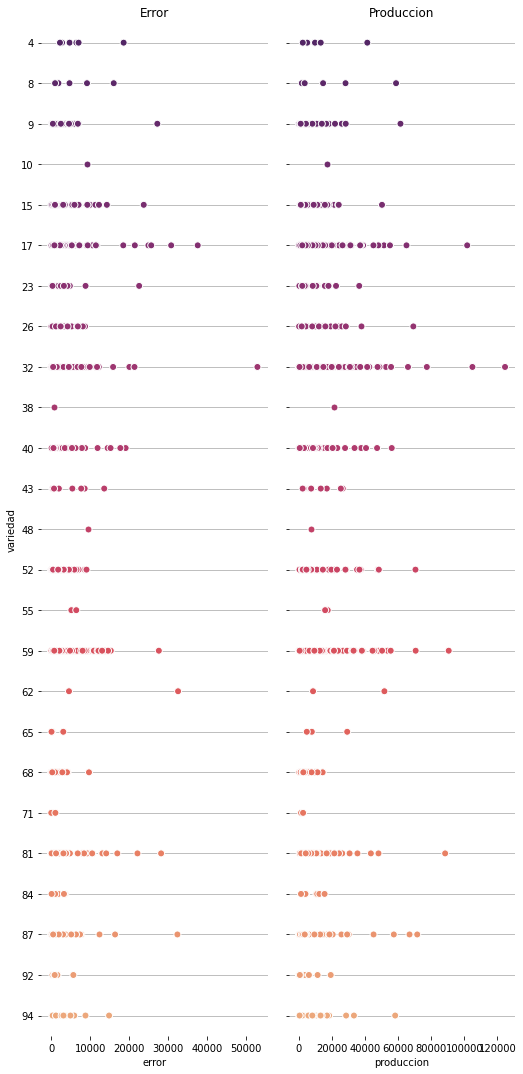

In [127]:
g = sns.PairGrid(df_errores,
                 x_vars=['error','produccion'], y_vars=["variedad"],
                 height=15, aspect=.25)

g.map(sns.stripplot, size=7, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

titles = ["Error", "Produccion"]

for ax, title in zip(g.axes.flat, titles):

    ax.set(title=title)

    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

## Transparencia

Memoria del modelo

- Instrucciones de uso 
- Tratamientos sobre los datasets de datos 
- Elección de la muestra de entrenamiento y validación 
- Argumento de la tipología del modelo a desarrollar 
- Criterios aplicados para la selección del ganador 
- Visualización y explicación de los resultados


Consideramos que todos estos puntos fueron tratados correctamente en el scrip de Predicción. En este, comentamos claramente los pasos seguidos y motivos por los cuales fuimos generando determinadas funciones o dejando de lado variables.

A la hora de seleccionar el modelo ganador, no solo hemos evaluado el puntaje para nuestro set de evaluación, sino tambien que tan bien le fue a este en un modelo con años pasados. Tambien tuvimos en cuenta la interpretación del modelo y los tiempos de ejecución de estos.

## Justicia

La IA debe usarse de forma justa, por lo que debe de velar por la equidad y evitar 
sesgos de  cualquier tipo. En el  desarrollo de  cualquier modelo, y desde el diseño, 
debe revisarse que la muestra es lo suficientemente representativa y que no existe 
ningún sesgo (ni en los datos utilizados en el entrenamiento ni en el 
comportamiento del propio modelo).

Para esto, corroboraremos  la  suficiente  diversidad  de  la 
muestra, así como la inexistencia de sesgos.

Es de ayuda la libreria **AI Fairness** https://aif360.mybluemix.net

PARA ESTO CREO QUE PODEMOS MOSTRAR LAS DISTRIBUCIONES DE TRAIN Y TEST, PARA LAS TODAS LAS VARIABLES

Importamos librerias

Comenzamos evaluando las distribuciones en el entrenamiento y validación. Para esto, cargamos los datasets finales y hacemos el split.

Recordar que realizamos el split en una forma temporal. Es decir, si el set de validación es 2021, el de entrenamiento serán todos los datos que sean de campañas anteriores a esta.

Evaluamos entrenamiento y validación para las variables mas importantes del modelo.

- El promedio de producción y superficie no presenta diferencias en ambos grupos.

In [5]:
print(f'El set de entrenamiento cuenta con {X_train.shape[0]} registros, mientras que el set de validación con {X_test.shape[0]} registros.')

El set de entrenamiento cuenta con 6334 registros, mientras que el set de validación con 1044 registros.


In [6]:
print(f'El promedio de la producción en uno y el otro es de {round(y_train.mean(),2)}kg y {round(y_test.mean(),2)}kg, respectivamente.')

El promedio de la producción en uno y el otro es de 9301.91kg y 9964.51kg, respectivamente.


In [7]:
print(f'El promedio de la superficie en uno y el otro es de {round(X_train.superficie.mean(),2)} hectarias y {round(X_test.superficie.mean(),2)} hectarias, respectivamente.')

El promedio de la superficie en uno y el otro es de 2.14 hectarias y 2.17 hectarias, respectivamente.


Tambien notamos que hay variedades de vino que tienen menores producciones y superficies, pero puede notarse una relacion entre estas dos ultimas.

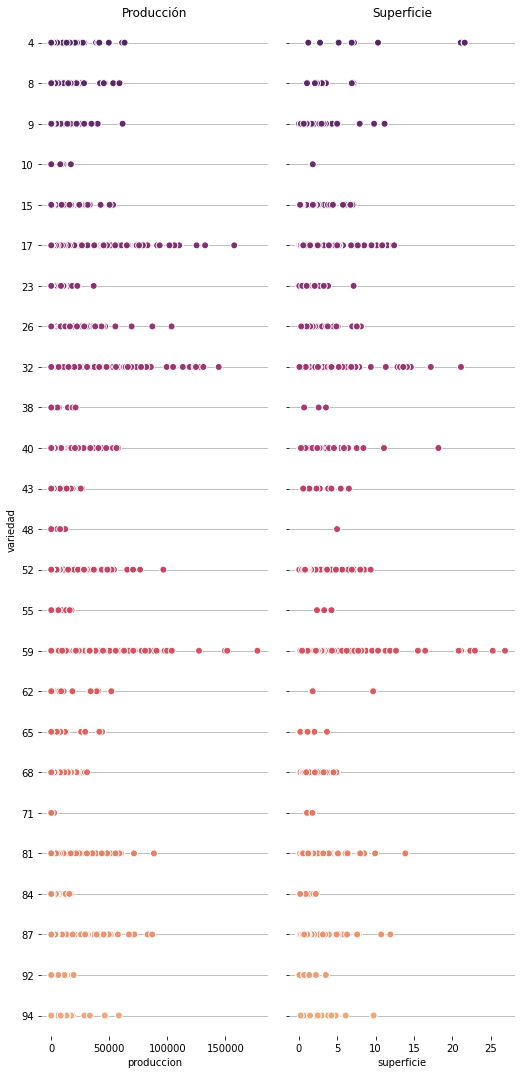

In [8]:
g = sns.PairGrid(data,
                 x_vars=['produccion','superficie'], y_vars=["variedad"],
                 height=15, aspect=.25)

g.map(sns.stripplot, size=7, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

titles = ["Producción", "Superficie"]

for ax, title in zip(g.axes.flat, titles):

    ax.set(title=title)

    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

Ahora revisamos el bias de las predicciones.

In [9]:
%%time 
models = []
for i in range(10):
    m = mm.get_final_model()
    m.set_params(randomforestregressor__random_state=mm.seed*(1+i))
    m.fit(X, y)
    models.append(m)

preds_final = []
for model in models:
    preds_final.append(model.predict(X_final))
y_pred_final = np.mean(preds_final,0)

Wall time: 4.37 s


Podemos evaluar las predicciones del modelo según la superficie de las fincas. Esto lo podemos realizar separandolas en percentiles:

In [10]:
Q1 = data_final.superficie.quantile(0.25)
Q2 = data_final.superficie.quantile(0.5)
Q3 = data_final.superficie.quantile(0.75)

Q1,Q2,Q3

(0.6126499999999999, 1.3, 2.7095000000000002)

In [11]:
bias_df = data_final.copy()
bias_df['preds'] = y_pred_final

bias_df['sup_q'] =[0 if x < Q1 else 1 if x < Q2 else 2 if x < Q3 else 3 for x in bias_df.superficie]

bias_df = bias_df[['superficie','sup_q','preds']]

Aunque no hay una relacion directa entre superficie y producción...

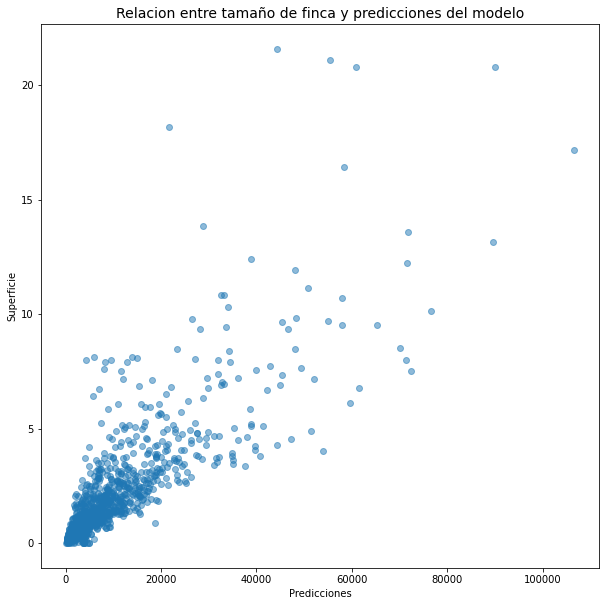

In [12]:
plt.figure(figsize=(10,10))
plt.scatter(x=bias_df.preds, y=bias_df.superficie , alpha=0.5)
plt.xlabel('Predicciones')
plt.ylabel('Superficie')
plt.title('Relacion entre tamaño de finca y predicciones del modelo', fontsize=14)
plt.show()

...si la hay entre el percentil de esta y las predicciones.

Sin embargo, no consideramos esto como un bias, ya que el tamaño de una finca es clave para conocer el potencial de producción que esta pueda tener.

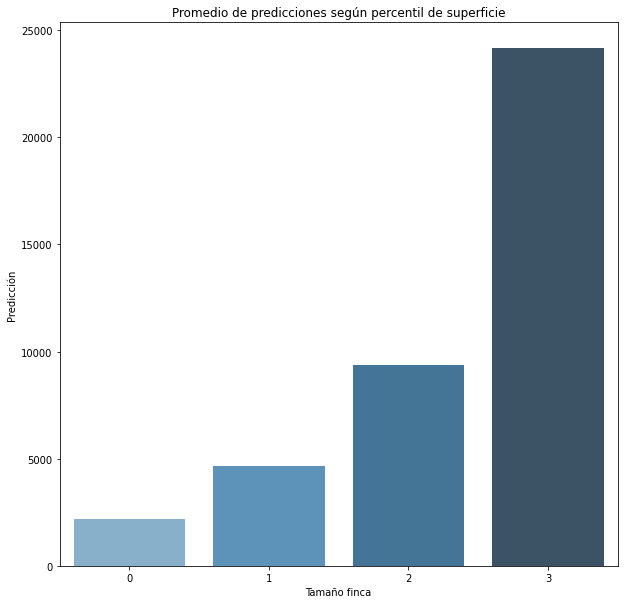

In [13]:
bias_avg = bias_df.groupby('sup_q')['preds'].agg('mean').reset_index()
plt.figure(figsize=(10,10))
sns.barplot(data=bias_avg, x='sup_q', y='preds',palette='Blues_d')
plt.xlabel('Tamaño finca')
plt.ylabel('Predicción')
plt.title('Promedio de predicciones según percentil de superficie')
plt.show()

## Sostenibilidad Ambiental

El desarrollo de los modelos de IA debe velar por la sostenibilidad y ser 
respetuosos con el medioambiente, por lo que se deberá asegurar la optimización 
computacional que garantice un menor consumo energético.

Este, comparado a otros intentos como Support Vector Machines o Redes Neuronales, resulta eficiente en terminos de sostenibilidad y optimización computacional.

Nuestro modelo, como se vio anteriormente, tardó 4.2 segundos en ejecutarse. Easto se traduce en un uso de 0.3 de la CPU.

In [14]:
import psutil
print('The CPU usage is: ', psutil.cpu_percent(4.2))

The CPU usage is:  3.1


En cuanto a memoria:

In [29]:
def run_model():
    models = []
    for i in range(10):
        m = mm.get_final_model()
        m.set_params(randomforestregressor__random_state=mm.seed*(1+i))
        m.fit(X, y)
        models.append(m)

    preds_final = []
    for model in models:
        preds_final.append(model.predict(X_final))
    y_pred_final = np.mean(preds_final,0)

In [28]:
run_model()

process = psutil.Process()
memory_usage = process.memory_info().rss / 1024 ** 2

print(f"El uso de memoria es de {memory_usage} MB")

El uso de memoria es de 493.04296875 MB


Nuestro modelo corre de manera eficiente, por lo que vela por la sostenibilidad ambiental. 

Si llegase a desarrollarse este modelo en la etapa de producción, no se necesitaría un gran poder computacional. Esto se debe especialmente al pequeño tamaño de la base de datos, determinado por su naturalidad de los tiempos de producción. 

# QUE VITO CORRA EN SU VS CODE EL RUN PREP A VER COMO DA LA INFO LOGGER